## Selección de variables

Reducir el número de variables originales y dejar únicamente las que son importantes. Para qué puede ser útil reducir el número de variables:

  * evitar el sobreajuste
  
  
  * entrenamiento y predicción más rápidos
  
  
  * reducir el espacio de almacenamiento necesario para el modelo y los datos
  
  
  * modelos más interpretables
  
  
Es raro que reduciendo el número de variables se obtenga un mejor modelo, ya que la mayoría de modelos tienen parámetros que controlan la cantidad de regularización para evitar el sobreajuste.

Sin embargo, si puede ser útil por motivos de **eficiencia** (espacio o tiempo) o por **interpretabilidad**.

[Guia de usuario](https://scikit-learn.org/stable/modules/feature_selection.html)

[Wikipedia. Feature selection](https://en.wikipedia.org/wiki/Feature_selection)    

### Tipos de selección de variables

 * Supervisado vs no supervisado
 
 
 * Univariante vs multivariante
 
 
 * Basado en modelo o no 
 
 
Nota: En la literatura clásica a veces se llama **métodos de filtro** a los métodos **no** basados en modelo. Para los métodos basados en modelos, se distinguen los **métodos de *wrapper*** (se pueden aplicar a cualquier modelo) y los **métodos embebidos** (la selección de variables forma parte del propio modelo)

### Eliminar variables correlacionadas

Método no supervisado, multivariante y no basado en modelo. 

La idea es eliminar variables que están muy correlacionadas.

In [1]:
import pandas as pd
from sklearn.datasets import load_boston

boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)

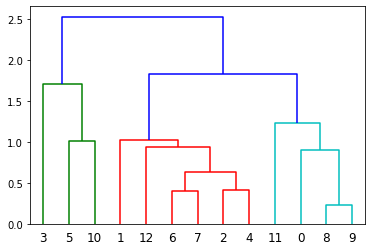

In [2]:
from scipy.cluster import hierarchy 

den = hierarchy.dendrogram(hierarchy.ward(X.corr().abs()))

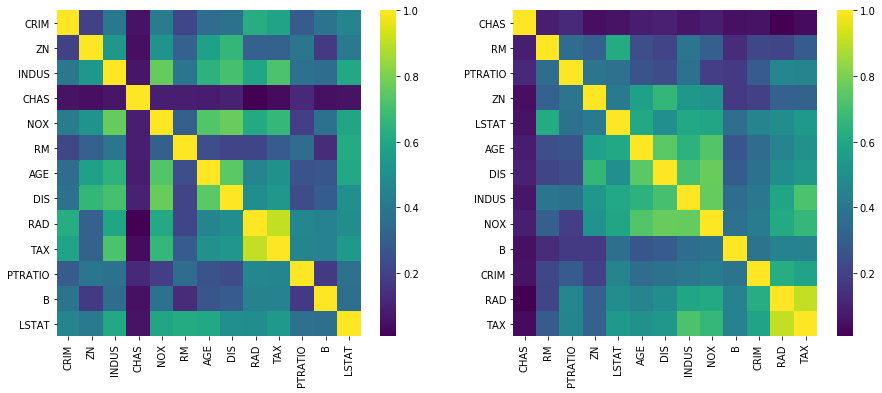

In [3]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(X.corr().abs(), cmap='viridis', ax=axes[0])

sns.heatmap(X.iloc[:, np.array(den['ivl'], dtype='int')].corr().abs(), cmap='viridis', ax=axes[1]);

### SelectKBest

La clase `SelectKBest` implementa un método de selección de variables **supervisado** y **univariante**. Selecciona las $k$ variables que tienen mayor dependencia con la variable de salida. Existen varias medidas de dependencia:

  * regresión: `f_regression`, `mutual_info_regression`

  * clasificación: `chi2`, `f_classif`, `mutual_info_classif`

In [4]:
from sklearn.feature_selection import SelectKBest, f_regression

In [5]:
X = boston.data
y = boston.target

f_values, p_values = f_regression(X, y)

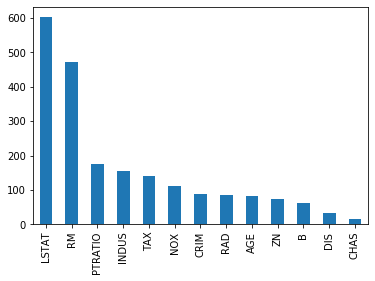

In [6]:
pd.Series(f_values, index=boston.feature_names).sort_values(ascending=False).plot(kind='bar');

In [7]:
kbest = SelectKBest(k=5, score_func=f_regression)
X_best = kbest.fit_transform(X, y)

In [8]:
X_best.shape

(506, 5)

### Análisis de componentes principales

Método **no supervisado** para reducir la dimensión. 

Transforma las variables originales en otras nuevas donde:

  * la primera captura la mayor parte de la varianza de los datos
  
  * la segunda la siguiente mayor
  
  * etc.
  
<img src=https://amueller.github.io/aml/_images/pca-intuition.png width=600>


En general, PCA hace el modelo **menos interpretable**, ya que las nuevas variables son combinaciones de las antiguas!!

Usos de PCA:

  * visualizar los datos
  
  
  * hacer el entrenamiento/predicción más eficientes, reduciendo el número de variables

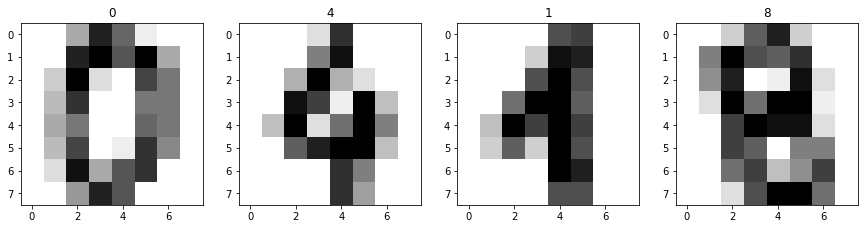

In [9]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

digits = load_digits(as_frame=True)

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for idx, ax in zip((0, 100, 200, 500), axes):
    ax.imshow(digits.data.iloc[idx].values.reshape((8, 8)), cmap=plt.cm.gray_r);
    ax.set_title(f'{digits.target[idx]}')

In [10]:
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

X = scale(digits.data)
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)

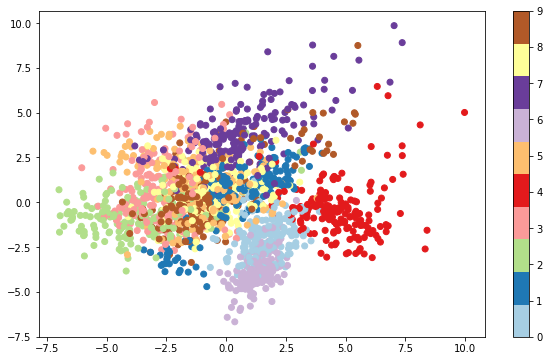

In [11]:
cmap = plt.get_cmap('Paired', 10)
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=digits.target, cmap=cmap)
plt.colorbar();

### Selección de variables basada en modelos

Idea:

  * Ajustar un modelo
  
  * Seleccionar variables importantes para el modelo
  
Multivariante y supervisado. Modelos que se usan:

  * modelos lineales (se miran los coeficientes)

  * modelos lineal con penalización $l_1$ (muchos coeficientes van a ser 0)
  
  * modelos basados en árboles (pueden calcular la importancia de las variables)

In [13]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

X = boston.data
y = boston.target

select_lassocv = SelectFromModel(LassoCV(), threshold=1e-5)
X_lasso = select_lassocv.fit_transform(X, y)

In [15]:
X_lasso.shape

(506, 10)

### Selección de variables iterativa

Implementado en las clases `RFE` (*recursive feature elimination*) y `RFECV`. La segunda elige automáticamente el número óptimo de variables usando validación cruzada. La idea es similar a `SelectFromModel` pero se eliminan las variables de forma iterativa:

  1. Se ajusta el modelo con todas las variables
  
  
  2. Se obtiene la importancia de cada variable (o bien mirando los coeficientes `coef_` o bien la importancia `feature_importances_`)
  
  
  3. Se elimina la variable menos importante y se vuelve a ajustar el modelo 
  
  
  4. Repetir hasta obtener número de variables deseado

In [16]:
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LinearRegression

rfecv = RFECV(LinearRegression(), cv=10)
X_rfe = rfecv.fit_transform(X, y)

In [17]:
X_rfe.shape

(506, 6)

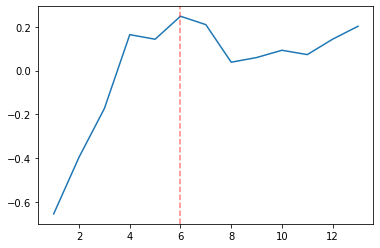

In [18]:
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.axvline(rfecv.n_features_, color='red', linestyle='--', alpha=0.5);

In [24]:
print(boston.feature_names[rfecv.get_support()])

['CHAS' 'NOX' 'RM' 'DIS' 'PTRATIO' 'LSTAT']


### Sequential Feature Selector

Método basado en modelo que va añadiendo o eliminando variables. Algunas características:

 * Se pueden aplicar a cualquier modelo
 
 
 * No están implementados en scikit-learn
 
 
 * Van eliminando o añadiendo variables (*Forward selection* o *Backwards selection*)
 
 
 * Similares a `RFE`, pero en lugar de usar los coeficientes o la importancia de características usan el error de validación cruzada
 
 
 * Implementados en la librería `mlxtend`: [Sequential Feature Selector](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/)
 
 
 * En la literatura clásica de estadística se conocen con el nombre de *stepwise regression*
 
 
 * Aproximación avariciosa del caso ideal (pero impracticable) de comparar todos los subconjuntos posibles de variables (*best subset selection*)
 
[Best Subset, Forward Stepwise, or Lasso?](https://www.stat.cmu.edu/~ryantibs/papers/bestsubset.pdf)

In [20]:
from mlxtend.feature_selection import SequentialFeatureSelector
sfs = SequentialFeatureSelector(LinearRegression(), forward=False, k_features=7)
X_back = sfs.fit_transform(X, y)

In [21]:
X_back.shape

(506, 7)

In [22]:
print(boston.feature_names[np.array(sfs.k_feature_idx_)])

['ZN' 'NOX' 'DIS' 'RAD' 'PTRATIO' 'B' 'LSTAT']
